# QR Code Detection

The general construction of a QR code is demonstrated in the following image, borrowed from [QR Code Detection and Extraction](http://dsynflo.blogspot.de/2014/10/opencv-qr-code-detection-and-extraction.html).
In the most general case, the code contains three positional markers, consisting of a black frame with a thickness of one unit, a white frame of one unit and a final enclosed black square of three units edge length.
When scanning the image pixelwise in either direction, this results in a `1-1-3-1-1` unit intensity pattern. When looking at the contours, the areas are `7x7-5x5-3x3` units.

<img src="doc/qr-code-parts.png" alt="Drawing" style="width: 480px;"/>

Additional QR code variants can be found [here](http://qrcode.meetheed.com/qrcode_examples.php). Some information on the construction of QR codes are [here](http://www.thonky.com/qr-code-tutorial/module-placement-matrix).

### Anaconda note

If you run Anaconda and Jupyter is not recognizing your environment, run 

```bash
conda install nb_conda
```

After restarting Jupyter you can then select the kernel matching your conda env.

## General imports

In [1]:
%matplotlib notebook
import cv2
import numpy as np
from matplotlib import pyplot as plt
from os import path
from glob import glob
from collections import defaultdict, deque
from itertools import combinations

## Code extraction

Let's quickly load and display an image containing a QR code:

In [2]:
def read_image(name: str) -> np.ndarray:
    file = glob(path.join('images', name + '.*'))[0]
    return cv2.imread(file, cv2.IMREAD_GRAYSCALE) / 255.

img = read_image('qr2')

<IPython.core.display.Javascript object>


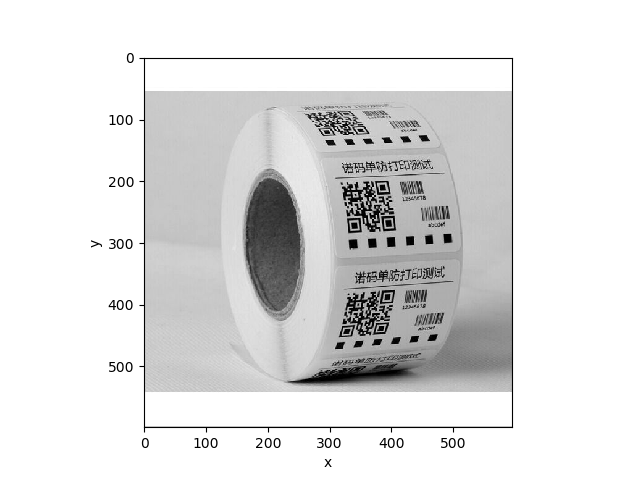

In [3]:
def plot(img: np.ndarray, title: str, xlabel: str='x', ylabel: str='y'):
    plt.figure(title)
    plt.imshow(img, cmap='gray')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

plot(img, 'Original (grayscale)')

Let's now take a look at the edges by obtaining an Laplacian-of-Gaussian filter.

<IPython.core.display.Javascript object>


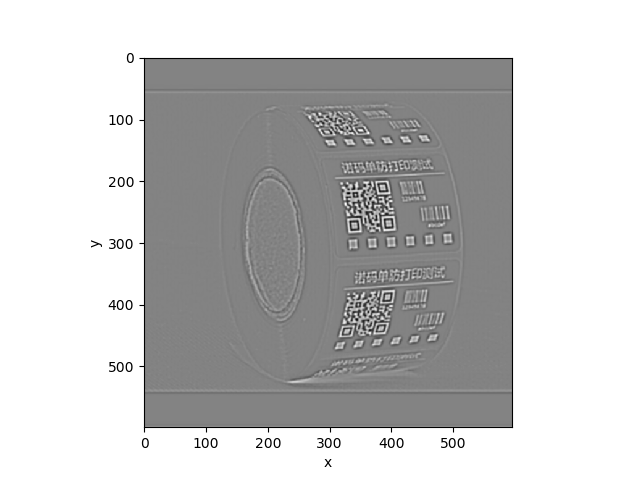

In [4]:
blur_kernel_size = (5, 5)
blurred = img
for i in range(3):
    blurred = cv2.GaussianBlur(blurred, blur_kernel_size, 0)

edges = cv2.Laplacian(blurred, cv2.CV_64F)
plot(edges, 'Edges (LoG)')

<IPython.core.display.Javascript object>


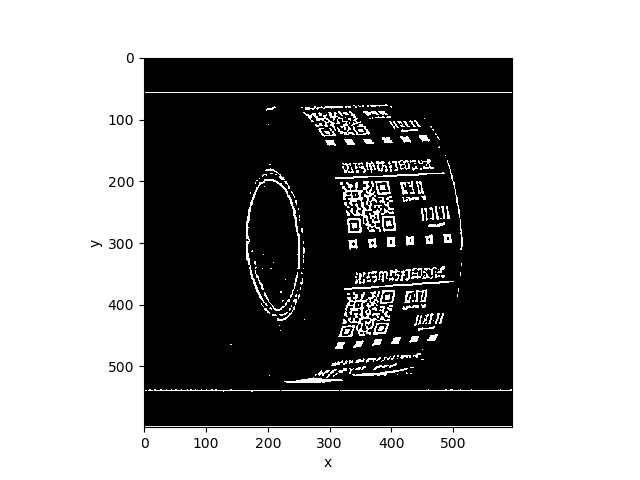

In [5]:
val, img_t = cv2.threshold(edges, thresh=.01, maxval=1., type=cv2.THRESH_BINARY)
plot(img_t, 'Thresholded edges')

We could apply a morphological closing operation to find big blobs of continous pixels, resulting in areas of interest to look at. Here, for example, the QR code itself results in a big blob. However, since QR codes are also allowed to be "empty", this idea might not work as expected.

<IPython.core.display.Javascript object>


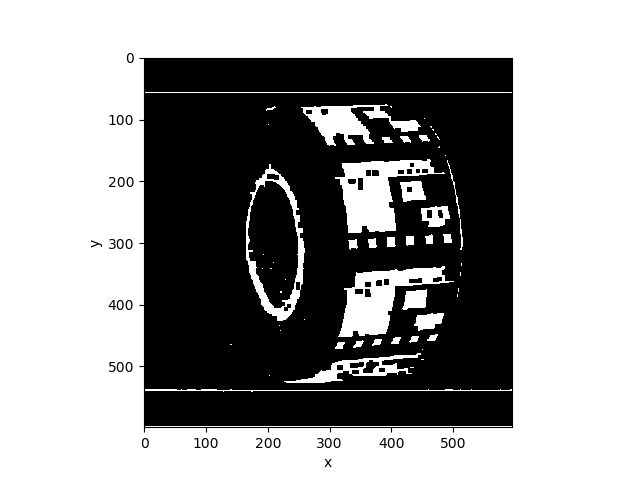

In [6]:
kernel = np.ones((7, 7), np.float32)
img_closed = cv2.morphologyEx(img_t, cv2.MORPH_CLOSE, kernel)
plot(img_closed, 'Closed edges')

In order discard small blobs, we need to evaluate them. OpenCV can do that for us already, so we simply run contour detection instead.
Here, `cv2.CHAIN_APPROX_SIMPLE` is used as an optimization: Since we are generally only interested in almost-linear shapes (i.e. the edges of the QR code), we simply store the edges of the contour rather than all border pixels.
We used `cv2.RETR_TREE` to also obtain the hierarchy of the contours: This way we can detect QR code marker candidates from the relation of their contour sizes.

In [7]:
img_tb = img_t.astype(np.uint8)
im2, contours, hierarchy = cv2.findContours(img_tb, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

assert hierarchy.shape[0] == 1
hierarchy = hierarchy[0]

The `hierarchy` list encodes relations of the found contours. The individual components are:

1. Next contour ID in the same hierarchy level
2. Previous contour ID in the same hierarchy level
3. First child contour ID
4. Parent contour ID

In [8]:
print(hierarchy)

[[  1  -1  -1  -1]
 [  2   0  -1  -1]
 [  3   1  -1  -1]
 ..., 
 [296 294  -1  -1]
 [297 295  -1  -1]
 [ -1 296  -1  -1]]


By definition of our problem we can drop all contours that neither have a parent, nor childs (i.e. end in `-1, -1`).

In [9]:
def filter_contours(cs, hs):
    has_childs = hierarchy[:, 2] >= 0
    has_parents = hierarchy[:, 3] >= 0
    cs, h = zip(*[(c, h) for i, (c, h) 
                  in enumerate(zip(contours, hierarchy)) 
                  if has_childs[i] or has_parents[i]])
    return cs, np.array(h)
    
filtered_contours, filtered_hierarchy = filter_contours(contours, hierarchy)
print(f'Contours: {len(filtered_contours)}, hierarchy tree: {filtered_hierarchy.shape}')

Contours: 63, hierarchy tree: (63, 4)


For validation purposes we convert the original `np.float32` grayscale image into an `np.uint8` RGB image:

In [10]:
img_u8 = (np.repeat(img[..., np.newaxis], 3, axis=2) * 255.).astype(np.uint8)

We can now draw the contours to see what OpenCV detected:

<IPython.core.display.Javascript object>


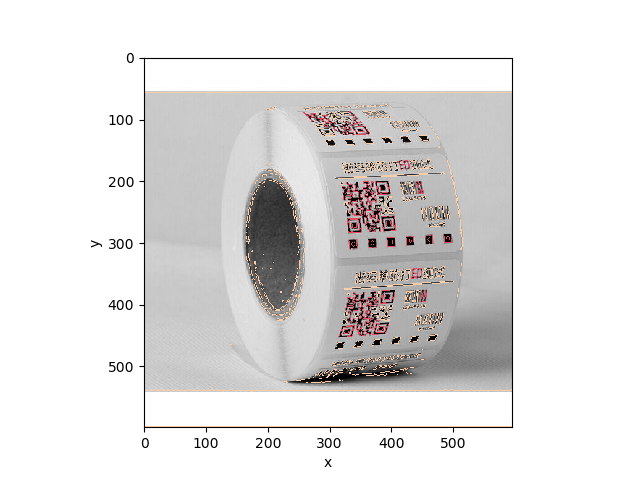

In [11]:
img_contours = img_u8.copy()
cv2.drawContours(img_contours, contours, -1, (254, 206, 168), 1)
cv2.drawContours(img_contours, filtered_contours, -1, (232, 74, 95), 1)
plot(img_contours, 'Filtered contours')

We now try to find contours that match the `7-5-3` area rule. Since we know the black square _should_ not contain any other contours, we start at the lowest level contours with parents and work our way up.

In [12]:
bottom_level_candidates = ((i, h) for (i, h) in enumerate(hierarchy) if h[2] == -1 and h[3] >= 0)
# bottom_level_candidates = ((i, h) for (i, h) in enumerate(hierarchy) if h[3] >= 0)

unchecked_candidates = []
candidates = []
edge_lengths = []

mse_threshold = 20.

for i, h in bottom_level_candidates:
    c3_idx, c5_idx = i, h[3]    
    c7_idx = hierarchy[c5_idx, 3]
    if c7_idx == -1:
        continue
        
    # If the image is large enough, we will see a double contour here.
    c7_2_idx = hierarchy[c7_idx, 3]
    if c7_2_idx != -1:
        c7_idx = c7_2_idx

    c3 = contours[c3_idx]
    if len(c3) < 4:
        continue
    
    c5 = contours[c5_idx]
    if len(c5) < 4:
        continue
    
    c7 = contours[c7_idx]
    unchecked_candidates.extend([c3, c5, c7])
        
    e3 = np.sqrt(cv2.contourArea(contours[c3_idx]))
    e5 = np.sqrt(cv2.contourArea(contours[c5_idx]))
    e7 = np.sqrt(cv2.contourArea(contours[c7_idx]))
    
    assert e3 > 0.
    assert e5 > 0.
    assert e7 > 0.
    
    e5_e3 = e5 / e3
    e7_e3 = e7 / e3
    e7_e5 = e7 / e5
        
    mse = (e5_e3 - 1.667)**2 + (e7_e3 - 2.333)**2 + (e7_e5 - 1.4)**2
    if mse < mse_threshold:
        candidates.append([c7, c5, c3])
        edge_lengths.append([e7, e5, e3])
        print(f'Candidate {c7_idx} > {c5_idx} > {c3_idx}:')
        print(f'  e5:e3 = {e5_e3:1.4f}\n'
              f'  e7:e3 = {e7_e3:1.4f}\n'
              f'  e7:e5 = {e7_e5:1.4f}\n'
              f'  MSE   = {mse:1.4f}')

Candidate 45 > 46 > 47:
  e5:e3 = 2.3086
  e7:e3 = 2.9486
  e7:e5 = 1.2772
  MSE   = 0.8056
Candidate 49 > 50 > 51:
  e5:e3 = 2.3631
  e7:e3 = 3.0664
  e7:e5 = 1.2976
  MSE   = 1.0329
Candidate 105 > 106 > 107:
  e5:e3 = 2.2830
  e7:e3 = 2.9405
  e7:e5 = 1.2880
  MSE   = 0.7611
Candidate 171 > 172 > 173:
  e5:e3 = 2.2268
  e7:e3 = 2.8474
  e7:e5 = 1.2787
  MSE   = 0.5927
Candidate 175 > 176 > 177:
  e5:e3 = 2.1954
  e7:e3 = 2.7949
  e7:e5 = 1.2731
  MSE   = 0.5086
Candidate 214 > 215 > 216:
  e5:e3 = 2.1730
  e7:e3 = 2.8146
  e7:e5 = 1.2953
  MSE   = 0.4989
Candidate 286 > 287 > 288:
  e5:e3 = 2.5386
  e7:e3 = 3.7268
  e7:e5 = 1.4681
  MSE   = 2.7069


<IPython.core.display.Javascript object>


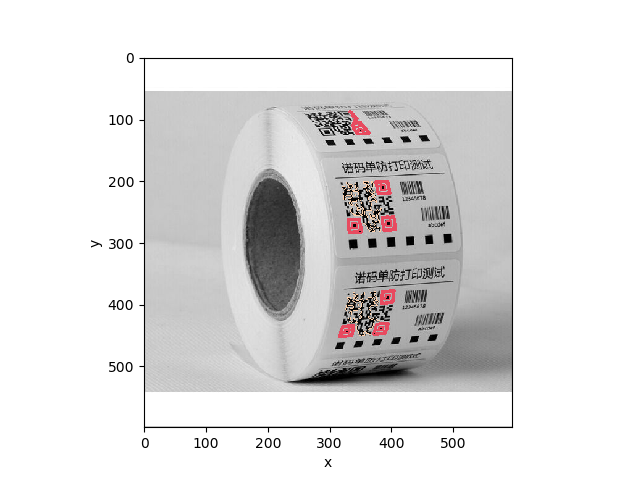

In [13]:
img_contours = img_u8.copy()
cv2.drawContours(img_contours, unchecked_candidates, -1, (254, 206, 168), 1)
for c in candidates:
    cv2.drawContours(img_contours, c, -1, (232, 74, 95), 2)
plot(img_contours, 'Candidate contours')

For each of the candidates, we can now determine the centroids:

In [14]:
def centroid(cnt, M=None) -> np.ndarray:
    # see http://docs.opencv.org/trunk/dd/d49/tutorial_py_contour_features.html
    M = M or cv2.moments(cnt)
    cx = int(M['m10'] / M['m00'])
    cy = int(M['m01'] / M['m00'])
    return np.array([cx, cy], dtype=np.int32)

In [15]:
centroids = [(centroid(c7) + centroid(c5) + centroid(c3)) // 3 
             for c7, c5, c3 in candidates]

for c in centroids:
    print(c)

[328 443]
[383 439]
[393 388]
[340 272]
[395 268]
[386 210]
[349 116]


The timing pattern of the QR code lies in the 7th row and column (i.e. column 6) and coincides with the edges that lie in the code. In order to detect these, we'll fit an oriented rectangle to the outermost contour.
However, in order to take perspective distortion into account, we'll instead approximate a general trapezoid using
OpenCV's [`approxPolyDP`](http://docs.opencv.org/3.1.0/d3/dc0/group__imgproc__shape.html#ga0012a5fdaea70b8a9970165d98722b4c) function. An example can be found in the [Contour Approximation](http://docs.opencv.org/3.1.0/dd/d49/tutorial_py_contour_features.html) section in the OpenCV Python Tutorial.

In [16]:
outer_rectangles = []

for c7, c5, c3 in candidates:
    perimeter = cv2.arcLength(c7, True)
    epsilon = .05 * perimeter
    rect = cv2.approxPolyDP(c7, epsilon, True)
    rect = rect.squeeze()
    if len(rect) != 4:
        continue
    outer_rectangles.append(rect.squeeze())

<IPython.core.display.Javascript object>


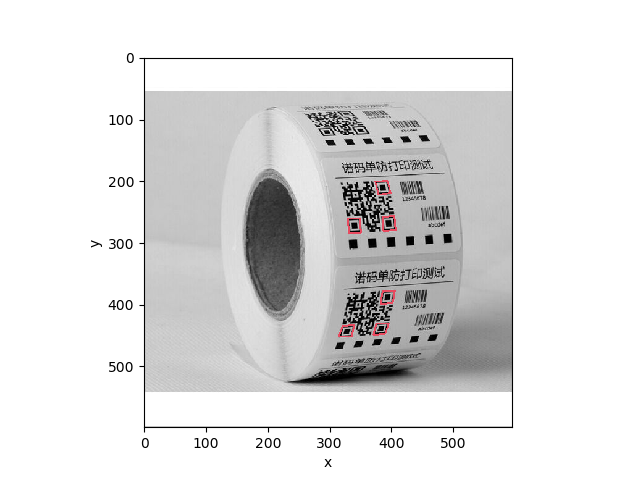

In [17]:
img_contours = img_u8.copy()
cv2.drawContours(img_contours, outer_rectangles, -1, (232, 74, 95), 2)
plot(img_contours, 'Marker rectangles')

There are now two pairs of markers that share two lines of the outer rectangle each. One of these lines per pair - the inner one - lies on the timing pattern.

We start by determining the vectors describing the edges of the marker trapezoid:

In [18]:
def norm(vector: np.ndarray) -> np.float32:
    return np.sqrt(np.dot(vector, vector.T))

def normalize(vector: np.ndarray) -> np.ndarray:
    return vector / norm(vector)

edge_vectors = []

for r in outer_rectangles:   
    h1 = normalize(r[1] - r[0])
    h2 = normalize(r[2] - r[3])
    v1 = normalize(r[3] - r[0])
    v2 = normalize(r[2] - r[1])
    d1 = normalize(r[2] - r[0])
    d2 = normalize(r[1] - r[3])   
    edge_vectors.append([h1, h2, v1, v2, d1, d2])

We can now find all markers that lie between the horizontal line pairs or vertical line pairs. By using a 2-dimensional variant of the vector cross product (the perp product) we can determine the distance and side of each centroid in relation to the edge lines.

In [19]:
def cross2d(a: np.ndarray, b: np.ndarray) -> np.float32:
    return a[0] * b[1] - a[1] * b[0]

def test_between_lines(h1, h2, v1, v2, candidate, rect) -> bool:
    x_h1 = cross2d(h1, candidate - rect[0])
    x_h2 = cross2d(h2, candidate - rect[3])
    x_v1 = cross2d(v1, candidate - rect[0])
    x_v2 = cross2d(v2, candidate - rect[1])

    # In theory we could check if the point is strictly right
    # of the upper _and_ left of the lower line. However, the order
    # of the contour points would have to be deterministical for
    # this and since we're really only dealing with points, it is 
    # sufficient to just check for the sign.
    h_match = np.sign(x_h1) != np.sign(x_h2)
    v_match = np.sign(x_v1) != np.sign(x_v2)
    
    # If the point is not on different sides of exactly one
    # line pair (horizontal or vertical), we drop it.
    is_valid = h_match ^ v_match
    sse = x_h1**2 + x_h2**2 if h_match else x_v1**2 + x_v2**2
    return is_valid, sse

def make_key(i: int, j: int):
    return min(i, j), max(i, j)

pairs = [(i, j) 
         for i in range(len(outer_rectangles) - 1) 
         for j in range(i + 1, len(outer_rectangles))]

links = defaultdict(set)
pair_sse = dict()

for i, j in pairs:
    i_r = outer_rectangles[i]
    j_r = outer_rectangles[j]
    i_c = centroids[i]
    j_c = centroids[j]
    i_h1, i_h2, i_v1, i_v2, _, _ = edge_vectors[i]
    j_h1, j_h2, j_v1, j_v2, _, _ = edge_vectors[j]

    is_valid, sse_1 = test_between_lines(i_h1, i_h2, i_v1, i_v2, j_c, i_r)
    if not is_valid:
        continue

    # By checking the other direction as well, we make
    # sure the other point sees us as a valid candidate, too.
    is_valid, sse_2 = test_between_lines(j_h1, j_h2, j_v1, j_v2, i_c, j_r)
    if not is_valid:
        continue

    pair_sse[make_key(i, j)] = sse_1 + sse_2
    links[i].add(j)
    links[j].add(i)

In [20]:
print('Links')
for (k, v) in links.items():
    print(k, v)

Links
0 {1}
1 {0, 2}
2 {1}
3 {4}
4 {3, 5}
5 {4}


In [21]:
print('Errors')
print(pair_sse)

Errors
{(0, 1): 433.6988950276243, (1, 2): 461.66933215781353, (3, 4): 567.20290434135654, (4, 5): 490.12976540920693}


We now collect all points that form a triangular reference chain. Using a similar logic as above we determine the distance of each centroid from the diagonal lines formed by the markers. The pair with the smallest error is considered to be the best match.

In [27]:
triangle_idx = []
triangles = []

i, j = None, None

for (p1, others) in links.items():
    if len(others) < 2:
        continue
        
    best_p2, best_p3 = None, None
    min_sse = float('+Inf')
    
    for p2, p3 in combinations(others, 2):       
        i_c = centroids[p2]
        j_c = centroids[p3]
        _, _, _, _, i_d1, i_d2 = edge_vectors[p2]
        _, _, _, _, j_d1, j_d2 = edge_vectors[p3]

        dist_d1 = cross2d(i_d1, j_c - i_c)
        dist_d2 = cross2d(i_d2, j_c - i_c)
        sse_d1 = min(dist_d1**2, dist_d2**2)
        
        dist_d1 = cross2d(j_d1, i_c - j_c)
        dist_d2 = cross2d(j_d2, i_c - j_c)
        sse_d2 = min(dist_d1**2, dist_d2**2)
        
        sse = sse_d1 + sse_d2
        if sse < min_sse:
            min_sse = sse
            best_p2, best_p3 = p2, p3
    
    triangle_idx.append((p1, p2, p3))
    triangles.append(np.array((centroids[p1], centroids[p2], centroids[p3])))
    
print(triangles)

[array([[383, 439],
       [328, 443],
       [393, 388]], dtype=int32), array([[395, 268],
       [340, 272],
       [386, 210]], dtype=int32)]


<IPython.core.display.Javascript object>


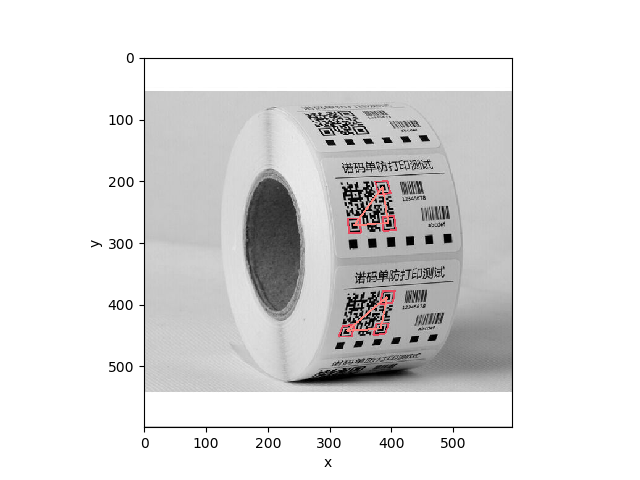

In [28]:
img_contours = img_u8.copy()
for i in [i for t in triangle_idx for i in t]:
    cv2.drawContours(img_contours, [outer_rectangles[i]], -1, (232, 74, 95), 2)
cv2.polylines(img_contours, triangles, True, (255, 132, 124), 2)
plot(img_contours, 'Triangles')